### Ticker Technical Analysis 
Uses ticker pricing data for given date range and analyzes the buy and sell signals. 

In [29]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

In [30]:
# enter ticker symbol and date range to retrieve

ticker = 'mu'
start_date = '2024-08-01'
end_date =  '2024-10-03'

In [31]:
# Fetch data for a ticker

df_intra = yf.download(ticker, start_date, end_date, interval='60m')
df = yf.download(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [32]:
# EMA Calculate function

def calculate_ema(fast_ema, slow_ema, df):
    fema = df['Close'].ewm(span=fast_ema, adjust=False).mean()
    sema = df['Close'].ewm(span=slow_ema, adjust=False).mean()
    return fema, sema

df['EMA_A'], df['EMA_B'] = calculate_ema(5, 7, df)


def calculate_ema_intra(ifast_ema, islow_ema, df_intra):
    fema_intra = df_intra['Close'].ewm(span=ifast_ema, adjust=False).mean()
    sema_intra = df_intra['Close'].ewm(span=islow_ema, adjust=False).mean()
    return fema_intra, sema_intra

df_intra['iEMA_A'], df_intra['iEMA_B'] = calculate_ema_intra(5, 7, df_intra)


In [33]:
# RSI Calulate function

def calculate_rsi(df, overbought_level, oversold_level):
    delta = df['Close'].diff(1)

    # Calculate the exponentially weighted moving averages of gains and losses
    gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
    loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

    # Calculate the relative strength (RS)
    rs = gain_ewm / loss_ewm

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    # Compute the median between overbought and oversold levels
    median_rsi = np.median([overbought_level, oversold_level])

    return rs, rsi, median_rsi

rs, rsi, median_rsi = calculate_rsi(df, 90, 10)

# Add the Median_RSI column indicating whether RSI is above or below the median
df['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

# add rsi column with rsi value
df['rsi'] = rsi

# # ensure rsi is above median to be used in the crossed_above condition
rsi_check = df['rsi'] >= median_rsi

In [34]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

df['MACD'], df['Signal'] = calculate_macd(df)

In [35]:
# Calculate Signal

def signal(df):
    crossed_above_with_rsi = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1)) & (rsi_check)
    crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1)) 
    crossed_above_macd = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))
    return crossed_above_with_rsi, crossed_above, crossed_above_macd

# Capture the output of the signal function
crossed_above_with_rsi, crossed_above, crossed_above_macd = signal(df)

def isignal(df):
    icrossed_above_with_rsi = (df_intra['iEMA_A'] > df['iEMA_B']) & (df_intra['iEMA_A'].shift(1) < df_intra['iEMA_B'].shift(1)) & (rsi_check)
    icrossed_above = (df_intra['iEMA_A'] > df_intra['iEMA_B']) & (df_intra['iEMA_A'].shift(1) < df_intra['iEMA_B'].shift(1)) 
    return icrossed_above_with_rsi, icrossed_above

# Capture the output of the signal function
icrossed_above_with_rsi, icrossed_above = isignal(df_intra)

### Result of the Signal function: 
will be added to dataframe & also the condition for crossed down.

In [36]:
# DAILY - This uses the result of the signal function.  
df.loc[crossed_above_with_rsi, 'Cross_Direction'] = 'crossed up'

# Identify when the A-day EMA crosses below the B-Day EMA
crossed_below = (df['EMA_A'] < df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))

df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

# Filter for rows where the 5-day EMA crossed either above or below the 21-day EMA
condition_met = df[df['Cross_Direction'].notna()]

# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
condition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Date,,,,,,
2024-08-13,97.440002,94.431326,94.330084,crossed up,above_median,57.611646
2024-08-26,98.910004,102.858625,103.055477,crossed down,below_median,39.198607
2024-09-20,90.900002,89.338566,89.251276,crossed up,above_median,52.350471


In [37]:
# INTRA DAY - This uses the result of the signal function.  
df_intra.loc[icrossed_above, 'Cross_Direction'] = 'crossed up'

# Identify when the A-day EMA crosses below the B-Day EMA
icrossed_below = (df_intra['iEMA_A'] < df_intra['iEMA_B']) & (df_intra['iEMA_A'].shift(1) > df_intra['iEMA_B'].shift(1))

df_intra.loc[icrossed_below, 'Cross_Direction'] = 'crossed down'

# Filter for rows where the 5-day EMA crossed either above or below the 21-day EMA
icondition_met = df_intra[df_intra['Cross_Direction'].notna()]

# Display the dates when the conditions were met and the direction of the crossover
print("\nInra Day Dates when the conditions were met and cross direction:")
icondition_met[['Close', 'iEMA_A', 'iEMA_B', 'Cross_Direction']]


Inra Day Dates when the conditions were met and cross direction:


,Close,iEMA_A,iEMA_B,Cross_Direction
Datetime,,,,
2024-08-07 09:30:00,90.989998,90.000772,89.979719,crossed up
2024-08-07 12:30:00,88.787598,89.698339,89.786331,crossed down
2024-08-08 10:30:00,91.010002,89.638671,89.488974,crossed up
2024-08-19 09:30:00,105.449997,107.073456,107.142135,crossed down
2024-08-19 14:30:00,107.849998,107.194167,107.119781,crossed up
2024-08-21 09:30:00,107.080002,107.615442,107.617671,crossed down
2024-08-21 13:30:00,107.849998,107.399074,107.395852,crossed up
2024-08-22 11:30:00,106.930000,107.340495,107.391496,crossed down
2024-08-29 10:30:00,97.260002,95.901138,95.731455,crossed up


### Plot 'crossed up' and 'crossed down' signals on line graph, and calculate total return


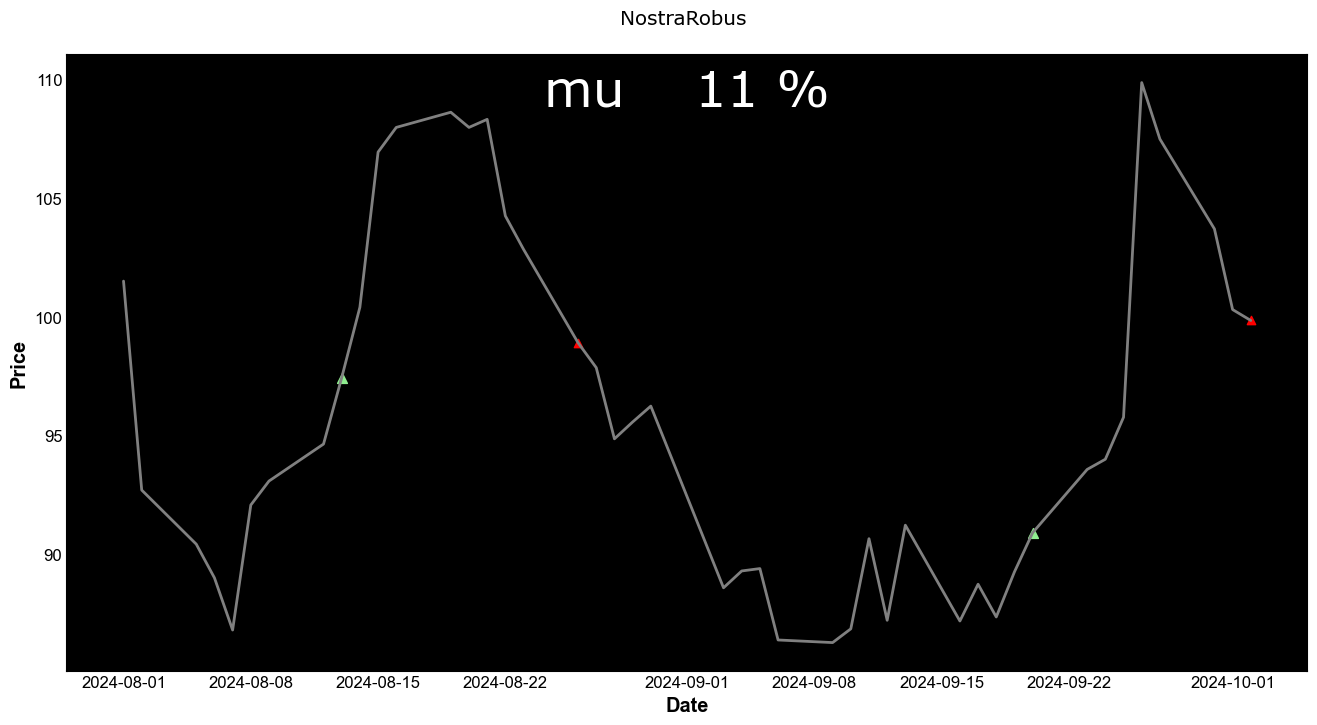

Results For Ticker:   mu
Initial Investment:  97.44000244140625
Final Portfolio Value:  107
Profit/Loss:  10.4
Percent: 10.7%




,Action,Date,Open,Close,Price,Cash
0,Buy,2024-08-13,96.620003,97.440002,97.440002,0.000000
1,Sell,2024-08-26,100.669998,98.910004,100.669998,98.910004
2,Buy,2024-09-20,88.400002,90.900002,90.900002,8.010002
3,Sell,2024-10-02,100.589996,99.849998,100.589996,107.860001


In [38]:
# Initialize variables
init_cost = 1 # we need this set so when conditions are not met, we don't divide by 0
cash = init_cost  # Initial cash balance
shares_owned = 0
portfolio_value = cash
prev_crossed_above = False
rsi_above_median = False
transactions = []
last_trans = 'crossed down'
df.iloc[-1, df.columns.get_loc('Cross_Direction')] = last_trans

# Plot the line graph with arrows indicating the direction of crossover
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='gray')
plt.gca().set_facecolor('black')  # Set the background color to black



# Find the first crossed up event and set the initial cost
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up':
        init_cost = row['Close']  # Set init_cost to the price at the first crossed up event
        cash = init_cost  # Set cash to the initial cost
        break

# Loop through the dataframe
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up' and prev_crossed_above == False:  # Check if the Cross_Direction column is 'crossed up'
        # Buy one share
        # shares_owned += 1
        cash -= row['Close']  # Deduct purchase price from cash
        transactions.append(('Buy', index, row['Open'], row['Close'], row['Close'], cash))
        prev_crossed_above = True
        plt.scatter(index, row['Close'], marker='^', color='lightgreen', s=50, label='Crossed Up')
    elif row['Cross_Direction'] == 'crossed down' and prev_crossed_above:  # Check if the Cross_Direction column is 'crossed down':
        cash += row['Close'] #* shares_owned  # Add sale price to cash
        transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], cash))
        prev_crossed_above = False
        plt.scatter(index, row['Close'], marker='^', color='red', label='Crossed Down')
    else:
        pass
    
# Calculate final portfolio value
portfolio_value = cash

# Evaluate performance
initial_investment = init_cost # Initial cash investment
profit_loss = portfolio_value - initial_investment

percent = (profit_loss / initial_investment) * 100

# Add the ticker symbol and other things as labels
plt.text(0.5, 0.9, ticker + '    ' + str(round(percent)) + ' %', transform=plt.gca().transAxes, fontsize=36, verticalalignment='bottom', \
         horizontalalignment='center', fontname='MS Reference Sans Serif', fontweight='bold', color='white')
plt.title('NostraRobus \n', fontname='MS Reference Sans Serif', fontweight='bold', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Price', color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.grid(False)
plt.show()



print('Results For Ticker:  ', ticker)
print('Initial Investment: ', initial_investment)
print("Final Portfolio Value: ", int(portfolio_value))
print("Profit/Loss: ", round(profit_loss,1))
print("Percent: {:.1f}%".format(percent))
print('\n')
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
transactions_df



### Same calculation as line graph but with candlestick graph

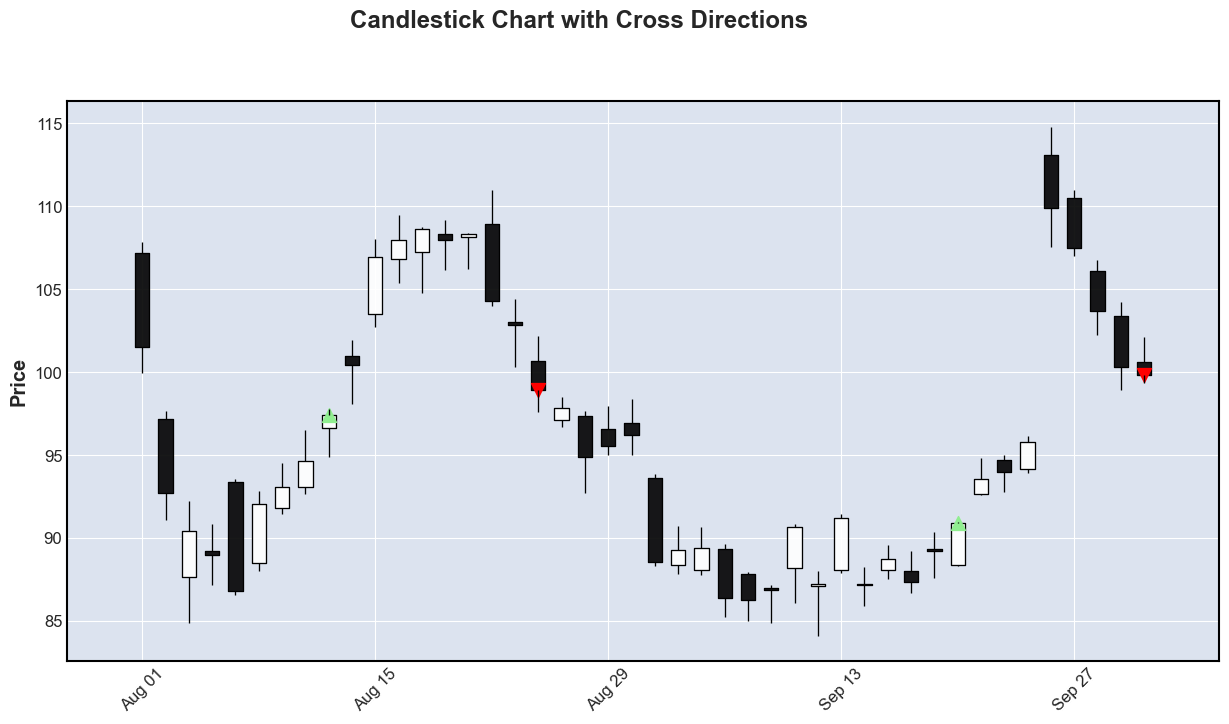

In [39]:
# Plot the candlestick chart with the custom black background
mpf.plot(
    df,
    type='candle',
    title='Candlestick Chart with Cross Directions',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(df['Cross_Direction'] == 'crossed up', df['Close'], np.nan),
            type='scatter',
            markersize=100,  # Marker size
            marker='^',      # Upward triangle for 'crossed up'
            color='lightgreen'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(df['Cross_Direction'] == 'crossed down', df['Close'], np.nan),
            type='scatter',
            markersize=100,  # Marker size
            marker='v',      # Downward triangle for 'crossed down'
            color='red'      # Color for 'crossed down'
        )
    ]
)


### Intraday Candlestick Graph

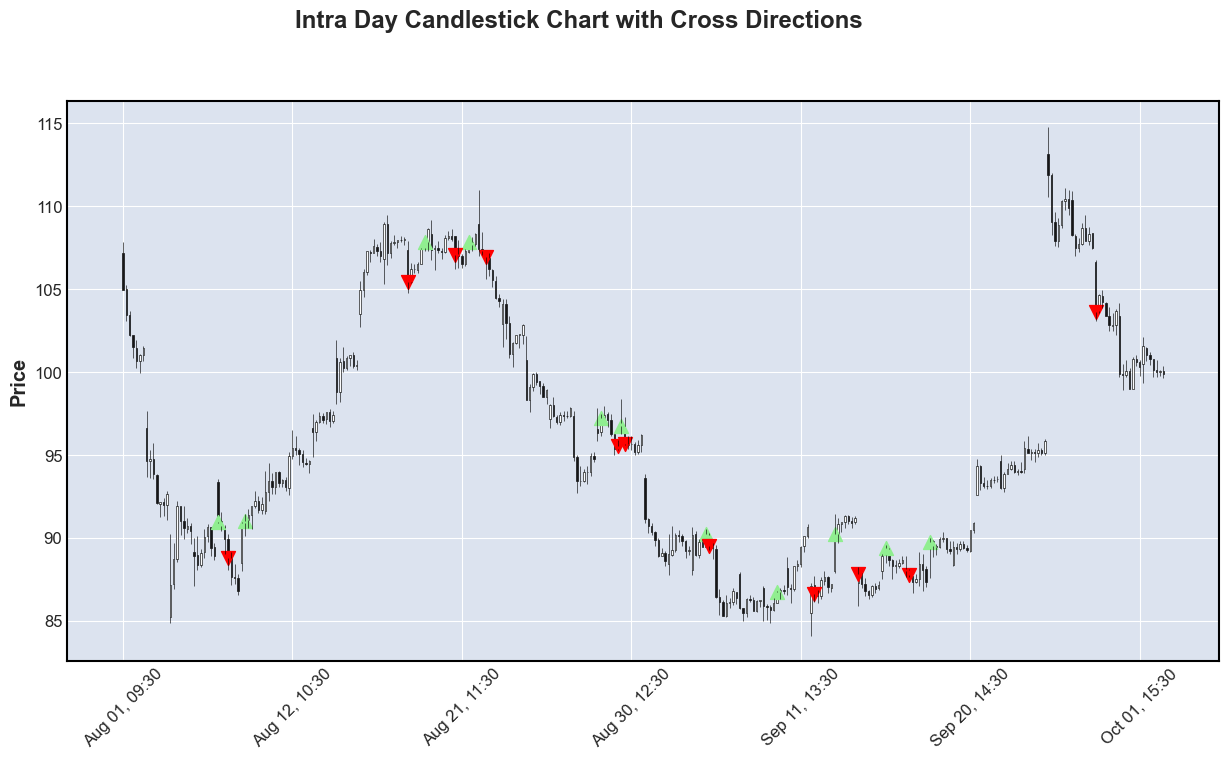

In [40]:
# Plot the INTRA DAY candlestick & SIGNAL chart with the custom black background
mpf.plot(
    df_intra,
    type='candle',
    title='Intra Day Candlestick Chart with Cross Directions',
    figsize=(16, 8),
    ylabel='Price',
    warn_too_much_data=len(df_intra) + 1,
    addplot=[
        mpf.make_addplot(
            np.where(df_intra['Cross_Direction'] == 'crossed up', df_intra['Close'], np.nan),
            type='scatter',
            marker='^',      # Upward triangle for 'crossed up'
            markersize=100,  # Marker size
            color='lightgreen'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(df_intra['Cross_Direction'] == 'crossed down', df_intra['Close'], np.nan),
            type='scatter',
            marker='v',      # Downward triangle for 'crossed down'
            markersize=100,  # Marker size
            color='red'      # Color for 'crossed down'
        )
    ]
)